## Graph 1.6

This notebook outlines the process of building a graph structure. The idea behind this structure is that each node represents a spectra. Each spectra has a certain amount of peaks witch are then assigned to gridslots. If two spectra have a peak in the same gridslot, they share a similar peak and a relationship can be created between them. This relationship can be weighted depending on how many "similar peaks" they share.

In [1]:
import pandas as pd
from scipy.signal import find_peaks
import seaborn as sns
import numpy as np
from scipy.signal import savgol_filter
from scipy import sparse
from scipy.sparse.linalg import spsolve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.signal import peak_widths
from scipy.signal import peak_prominences
from scipy.integrate import simps
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import os

In [2]:
password = os.getenv('NEO4J_Password')
neo4j_directory = os.getenv('NEO4J_Directory')

In [3]:
df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")

In [4]:
def modified_z_score(ys):
    ysb = np.diff(ys) # Differentiated intensity values
    median_y = np.median(ysb) # Median of the intensity values
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ysb]) # median_absolute_deviation of the differentiated intensity values
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in ysb] # median_absolute_deviationmodified z scores
    return modified_z_scores
    
# The next function calculates the average values around the point to be replaced.
def fixer(y,ma):
    threshold = 7 # binarization threshold
    spikes = abs(np.array(modified_z_score(y))) > threshold
    y_out = y.copy()
    for i in np.arange(len(spikes)):
        if spikes[i] != 0:
            w = np.arange(i-ma,i+1+ma)
            we = w[spikes[w] == 0]
            if len(we) > 0:  # Check if we has at least one valid value
                y_out[i] = np.mean(y[we])
    return y_out

def despike_group(absorbances):
    absorbance_data = absorbances.to_numpy()
    despiked_absorbance = fixer(absorbance_data, ma=10)
    return(despiked_absorbance)

df['Despiked_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x))

In [5]:
def baseline_als_optimized(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w) # Do not create a new matrix, just update diagonal values
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return y - z

lam = 10 ** 8
p = 0.05
df['Baseline_Corrected_Absorbance'] = df.groupby('SpecID')['Despiked_Absorbance'].transform(lambda x: baseline_als_optimized(x, lam=lam, p=p))

In [6]:
# Set the window size and polynomial order for the Savitzky-Golay filter
window_size = 9
poly_order = 2

# Apply Savitzky-Golay filter to smooth the Absorbance values
df['Smoothed_Absorbance'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))

In [7]:
def normalise(absorbances):
    max_value = np.max(absorbances)
    normalized_absorbances = absorbances / max_value
    return normalized_absorbances

df['Scaled_Absorbance'] = df.groupby('SpecID')['Smoothed_Absorbance'].transform(lambda x: normalise(x))

In [8]:
spectra_df = df.drop(columns=['Absorbance', 'Baseline_Corrected_Absorbance', 'Smoothed_Absorbance','Despiked_Absorbance'])

In [9]:
spectra_df = spectra_df.rename(columns={'Scaled_Absorbance':'Absorbance'})

In [10]:
peaks = []
widths = []
prominences = []
areas = []

df = spectra_df.copy()

# Find the index and width of each peak
for _, group in df.groupby('SpecID'):

    peak_index, _ = find_peaks(x=group['Absorbance'], distance = 38, prominence=32/3200, width=4)
    #peak_index, _ = find_peaks(x=group['Absorbance'])
    #peak_index, _ = find_peaks(x=group['Absorbance'], prominence=75)

    # Calculate the widths of each peak
    widths += list(peak_widths(group['Absorbance'], peaks=peak_index, rel_height=0.5)[0])

    # Calculate prominence of each peak
    prominences += list(peak_prominences(group['Absorbance'], peaks=peak_index)[0])

    # Find the index of the peak within the full dataframe
    peaks += list(group.iloc[peak_index].index.values)

peaks_df = df.iloc[peaks]

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

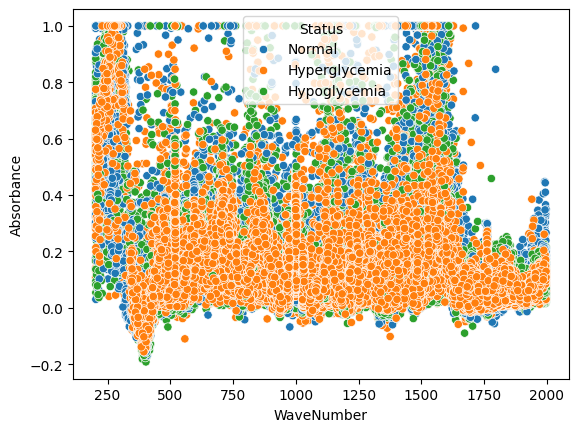

In [11]:
sns.scatterplot(data=peaks_df, x="WaveNumber", y="Absorbance", hue="Status")

In [12]:
def assign_to_grid(x, y, x_slot_size, y_slot_size):

    x_index = int(x / x_slot_size)
    y_index = int(y / y_slot_size)

    return x_index, y_index

In [13]:
peak_df = peaks_df

In [14]:
len(peak_df)

97965

In [15]:
# Set the size of the grid slots
WaveNumber_slot_size = 50
Absorbance_slot_size = 0.025

peak_df['GridSlot'] = peak_df.apply(lambda row: assign_to_grid(row['WaveNumber'], row['Absorbance'], WaveNumber_slot_size, Absorbance_slot_size), axis=1)

C:\Users\stang\AppData\Local\Temp\ipykernel_21612\1009779721.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_df['GridSlot'] = peak_df.apply(lambda row: assign_to_grid(row['WaveNumber'], row['Absorbance'], WaveNumber_slot_size, Absorbance_slot_size), axis=1)


In [16]:
peak_df['GridSlot'].nunique()

1215

In [17]:
peak_df['Node_ID'] = peak_df.index

C:\Users\stang\AppData\Local\Temp\ipykernel_21612\412265839.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_df['Node_ID'] = peak_df.index


In [18]:
peak_df = peak_df.drop(columns=['Seq', 'SurID']) # Dropping irrelevant columns

In [19]:
peak_df = peak_df.drop(columns=['WaveNumber', 'Absorbance', 'Node_ID']) # Dropping irrelevant columns

In [20]:
peak_df

,SpecID,Status,GridSlot
76,201210-1-00,Normal,"(5, 34)"
115,201210-1-00,Normal,"(5, 31)"
212,201210-1-00,Normal,"(6, -2)"
257,201210-1-00,Normal,"(7, 0)"
337,201210-1-00,Normal,"(8, 0)"
...,...,...,...
8010144,210526-3-49,Hyperglycemia,"(36, 3)"
8010192,210526-3-49,Hyperglycemia,"(37, 4)"
8010230,210526-3-49,Hyperglycemia,"(37, 2)"
8010332,210526-3-49,Hyperglycemia,"(39, 4)"


In [21]:
num_peaks = peak_df.groupby("SpecID").count()

In [22]:
print(num_peaks['Status'].min())
print(num_peaks['Status'].max())
print(num_peaks['Status'].mean())
print(num_peaks['Status'].median())

12
50
32.172413793103445
33.0


In [23]:
from itertools import combinations

def process_dataframe(df):
    # Group by GridSlot and aggregate SpecID into lists
    grouped = df.groupby('GridSlot')['SpecID'].apply(list).reset_index()

    # Filter out GridSlots with less than 2 unique SpecIDs
    filtered = grouped[grouped['SpecID'].map(lambda x: len(set(x)) > 1)]

    # Generate all combinations of SpecID pairs for each GridSlot and count occurrences
    pairs_count = {}
    for specids in filtered['SpecID']:
        for pair in combinations(set(specids), 2):
            sorted_pair = tuple(sorted(pair))  # Ensure consistent order
            if sorted_pair in pairs_count:
                pairs_count[sorted_pair] += 1
            else:
                pairs_count[sorted_pair] = 1

    # Create a new dataframe from the pairs_count dictionary
    result_df = pd.DataFrame([(pair[0], pair[1], count) for pair, count in pairs_count.items()],
                             columns=['SpecID1', 'SpecID2', 'Count'])

    return result_df

In [24]:
relationship_df = process_dataframe(peak_df)

In [25]:
relationship_df

,SpecID1,SpecID2,Count
0,210324-1-17,210407-1-04,3
1,210407-1-03,210407-1-04,3
2,210324-1-17,210407-1-03,2
3,210318-1-14,210407-1-02,4
4,210217-2-45,210318-1-14,3
...,...,...,...
4445942,210114-2-17,210414-3-42,1
4445943,210114-2-36,210414-3-42,1
4445944,210114-2-16,210114-2-37,1
4445945,210114-1-10,210114-2-24,1


In [26]:
relationship_df.rename(columns={'SpecID1':'SpecID1:START_ID', 'SpecID2':'SpecID2:END_ID', 'Count':'Weight:float'}, inplace=True)
relationship_df[':TYPE'] = 'LINK'

In [27]:
peak_df

,SpecID,Status,GridSlot
76,201210-1-00,Normal,"(5, 34)"
115,201210-1-00,Normal,"(5, 31)"
212,201210-1-00,Normal,"(6, -2)"
257,201210-1-00,Normal,"(7, 0)"
337,201210-1-00,Normal,"(8, 0)"
...,...,...,...
8010144,210526-3-49,Hyperglycemia,"(36, 3)"
8010192,210526-3-49,Hyperglycemia,"(37, 4)"
8010230,210526-3-49,Hyperglycemia,"(37, 2)"
8010332,210526-3-49,Hyperglycemia,"(39, 4)"


In [28]:
node_df = peak_df.groupby(['SpecID', 'Status']).size().reset_index()

In [29]:
node_df.drop(columns=[0], inplace=True)

In [30]:
node_df.rename(columns={'SpecID':'SpecID:ID', 'Status':'Status:LABEL'}, inplace=True)

In [31]:
relationship_df.to_csv(f"{neo4j_directory}/import/relationships.csv", index=False)

In [32]:
relationship_df['Weight:float'].mean()

3.6808412246029922

In [33]:
node_df.to_csv(f"{neo4j_directory}/import/nodes.csv")

In [34]:
node_df

,SpecID:ID,Status:LABEL
0,201210-1-00,Normal
1,201210-1-01,Normal
2,201210-1-02,Normal
3,201210-1-03,Normal
4,201210-1-04,Normal
...,...,...
3040,210526-3-45,Hyperglycemia
3041,210526-3-46,Hyperglycemia
3042,210526-3-47,Hyperglycemia
3043,210526-3-48,Hyperglycemia


#### This Version Creates the Graph in Neo4J then runs the Queries.

In [35]:
from neo4j import GraphDatabase
import os
import pandas as pd
import shutil
import subprocess

This moves the nodes and relationships files from data/current_working_graph into the DBMS import folder.

At the moment this uses local paths, but the rest should be automated.

Then run the admin import command.

In [36]:
os_name = os.name

if os_name == 'nt':
    working_dir = f'{neo4j_directory}/bin'
    command = 'neo4j-admin database import full --nodes=import/nodes.csv --relationships=import/relationships.csv --overwrite-destination neo4j'
    result = subprocess.run(command, shell=True, cwd=working_dir, capture_output=True, text=True)
else:
    working_dir = f'{neo4j_directory}'
    command = [
    './bin/neo4j-admin', 'database', 'import', 'full',
    '--nodes=import/nodes.csv',
    '--relationships=import/relationships.csv',
    '--overwrite-destination',  'neo4j'
    ]
    result = subprocess.run(command, cwd=working_dir, stdout=subprocess.PIPE, stderr=subprocess.PIPE)


# Check if the command was successful
if result.returncode == 0:
    print("Import successful")
    print(result.stdout)
else:
    print("Error during import:")
    print(result.stderr)

Import successful
Neo4j version: 5.12.0
Importing the contents of these files into C:\Users\stang\.Neo4jDesktop\relate-data\dbmss\dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351\data\databases\neo4j:
Nodes:
  C:\Users\stang\.Neo4jDesktop\relate-data\dbmss\dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351\import\nodes.csv

Relationships:
  C:\Users\stang\.Neo4jDesktop\relate-data\dbmss\dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351\import\relationships.csv


Available resources:
  Total machine memory: 31.86GiB
  Free machine memory: 13.22GiB
  Max heap memory : 910.5MiB
  Max worker threads: 8
  Configured max memory: 11.18GiB
  High parallel IO: true

Cypher type normalization is enabled (disable with --normalize-types=false):
  Property type of 'Weight' normalized from 'float' --> 'double' in C:\Users\stang\.Neo4jDesktop\relate-data\dbmss\dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351\import\relationships.csv

Import starting 2024-03-22 16:05:41.469+0000
  Estimated number of nodes: 3.05 k
  Estimated numbe

Run and connect to the Neo4j Database

In [39]:
from neo4j import GraphDatabase

uri = "neo4j://localhost:7687"
username = "neo4j"              # Neo4J username
#password = os.environ['NEO4J_Password']           # Neo4J password
#Password defined at the top of the notebook

# Create a driver instance
driver = GraphDatabase.driver(uri, auth=(username, password))

# Ensure you close the driver connection when your program ends
def close_driver():
    driver.close()

**First create the gds Graph Projection**

In [40]:
def project_graph(tx):
    query = """
    CALL gds.graph.project(
      'myGraph', 
      ['Normal', 'Hyperglycemia', 'Hypoglycemia'],
      {
        LINK: {
          orientation: 'UNDIRECTED',
          properties: 'Weight'
        }
      }
    )
    """
    tx.run(query)

# Use a session to execute the graph projection
with driver.session() as session:
    session.execute_write(project_graph)

Define the graph algorithms.

In [41]:
def run_pagerank_centrality(tx):
    query = """
    CALL gds.pageRank.stream('myGraph', {
        relationshipWeightProperty: 'Weight'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["score"]) for record in results]

In [42]:
def run_degree_centrality(tx):
    query = """
    CALL gds.degree.stream('myGraph', {
        relationshipWeightProperty: 'Weight'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["score"]) for record in results]

In [43]:
def run_eigenvector_centrality(tx):
    query = """
    CALL gds.eigenvector.stream('myGraph', {
        relationshipWeightProperty: 'Weight'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["score"]) for record in results]

In [44]:
def run_articlerank_centrality(tx):
    query = """
    CALL gds.articleRank.stream('myGraph', {
        relationshipWeightProperty: 'Weight'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["score"]) for record in results]

In [45]:
def run_label_propagation_algorithm(tx):
    query = """
    CALL gds.labelPropagation.stream('myGraph', { relationshipWeightProperty: 'Weight' })
    YIELD nodeId, communityId AS Community
    RETURN gds.util.asNode(nodeId).SpecID AS name, Community
    ORDER BY Community, name
    """
    results = tx.run(query)
    return [(record["name"], record["Community"]) for record in results]

In [46]:
def run_leiden_algorithm(tx):
    query = """
    CALL gds.leiden.stream('myGraph', { relationshipWeightProperty: 'Weight' })
    YIELD nodeId, communityId AS Community
    RETURN gds.util.asNode(nodeId).SpecID AS name, Community
    ORDER BY Community, name
    """
    results = tx.run(query)
    return [(record["name"], record["Community"]) for record in results]

In [47]:
def run_louvain_algorithm(tx):
    query = """
    CALL gds.louvain.stream('myGraph', { relationshipWeightProperty: 'Weight' })
    YIELD nodeId, communityId AS Community
    RETURN gds.util.asNode(nodeId).SpecID AS name, Community
    ORDER BY Community, name
    """
    results = tx.run(query)
    return [(record["name"], record["Community"]) for record in results]

In [48]:
def run_fastRP_algorithm(tx):
    query = """
    CALL gds.fastRP.stream('myGraph',
        { relationshipWeightProperty: 'Weight',
         randomSeed:1234,
         embeddingDimension: 128
        }
    )
    YIELD nodeId, embedding
    RETURN gds.util.asNode(nodeId).SpecID AS name,  embedding
    """
    results = tx.run(query)
    return [(record["name"], record["embedding"]) for record in results]

Execute the algorithms and store the results in a Dataframe.

In [49]:
# Use a session to execute the queries and retrieve the results
with driver.session() as session:
    pagerank_results = session.execute_read(run_pagerank_centrality)
    degree_results = session.execute_read(run_degree_centrality)
    eigenvector_results = session.execute_read(run_eigenvector_centrality)
    articlerank_results = session.execute_read(run_articlerank_centrality)
    label_propagation_results = session.execute_read(run_label_propagation_algorithm)
    leiden_results = session.execute_read(run_leiden_algorithm)
    louvain_results = session.execute_read(run_louvain_algorithm)

In [50]:
pagerank_df = pd.DataFrame(pagerank_results, columns=['name', 'PageRank'])
degree_df = pd.DataFrame(degree_results, columns=['name', 'DegreeCentrality'])
eigenvector_df = pd.DataFrame(eigenvector_results, columns=['name', 'EigenvectorCentrality'])
articlerank_df = pd.DataFrame(articlerank_results, columns=['name', 'ArticleRank'])
label_propagation_df = pd.DataFrame(label_propagation_results, columns=['name', 'LabelPropagation'])
leiden_df = pd.DataFrame(leiden_results, columns=['name', 'Leiden'])
louvain_df = pd.DataFrame(louvain_results, columns=['name', 'Louvain'])

In [51]:
merged_df = pagerank_df
for df in [degree_df, eigenvector_df, articlerank_df, label_propagation_df, leiden_df, louvain_df]:
    merged_df = pd.merge(merged_df, df, on='name', how='left')

In [52]:
df = merged_df.rename(columns={'name' : 'SpecID'})
df

,SpecID,PageRank,DegreeCentrality,EigenvectorCentrality,ArticleRank,LabelPropagation,Leiden,Louvain
0,210519-3-01,1.522488,18235.0,0.029951,0.659144,1,2548,1519
1,210217-2-11,1.504415,18017.0,0.029593,0.652600,1,2548,1519
2,210217-2-05,1.471457,17589.0,0.028890,0.640493,1,2548,1519
3,210217-2-04,1.471432,17591.0,0.028893,0.640519,1,2548,1519
4,210217-2-18,1.469541,17574.0,0.028865,0.639833,1,2548,1519
...,...,...,...,...,...,...,...,...
3040,210519-2-37,0.417426,3510.0,0.005765,0.248813,1,2548,1519
3041,210114-1-17,0.399481,3243.0,0.005327,0.241883,1,1,699
3042,210304-2-20,0.397664,3213.0,0.005277,0.241136,1,1,699
3043,210211-2-27,0.386780,3080.0,0.005059,0.237206,1,1,699


In [53]:
with driver.session() as session:
    fastRP_results = session.execute_read(run_fastRP_algorithm)

fastRP_df = pd.DataFrame(fastRP_results, columns=['SpecID', 'embeddings'])

# Expand the embeddings list into separate columns
embeddings_df = pd.DataFrame(fastRP_df['embeddings'].tolist(), index=fastRP_df.index)

# Optionally, rename the new columns
embeddings_df.columns = [f'embedding_{i}' for i in range(embeddings_df.shape[1])]

# Join the new embeddings columns to the original DataFrame
fastRP_df = pd.concat([fastRP_df.drop(['embeddings'], axis=1), embeddings_df], axis=1)
fastRP_df.to_csv('../../data/fastRP_embeddings.csv', index=False)
fastRP_df.head()

,SpecID,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127
0,201210-1-00,-0.094455,0.099944,0.287409,0.050123,0.212333,-0.032288,-0.103237,-0.027520,0.109598,...,-0.095761,0.062123,-0.115303,0.241323,0.344065,-0.063180,0.027856,-0.259700,-0.015398,-0.122710
1,201210-1-01,-0.092612,0.101229,0.287077,0.045925,0.207995,-0.030632,-0.108253,-0.028547,0.113664,...,-0.098092,0.061850,-0.117484,0.245142,0.347271,-0.065017,0.031715,-0.265022,-0.016487,-0.121779
2,201210-1-02,-0.080601,0.114625,0.280858,0.013533,0.192888,-0.020398,-0.143811,-0.032157,0.127127,...,-0.097453,0.069621,-0.128122,0.267225,0.346957,-0.073110,0.039768,-0.286360,-0.011784,-0.091578
3,201210-1-03,-0.081156,0.115383,0.276869,0.020215,0.193098,-0.017937,-0.155939,-0.032144,0.135853,...,-0.092588,0.074593,-0.131894,0.270081,0.342204,-0.072464,0.040995,-0.289523,-0.009354,-0.099006
4,201210-1-04,-0.092021,0.100881,0.294453,0.049285,0.215178,-0.026967,-0.106459,-0.034520,0.111700,...,-0.097410,0.065937,-0.119674,0.241584,0.341392,-0.060085,0.031612,-0.259430,-0.014082,-0.117692


In [54]:
df

,SpecID,PageRank,DegreeCentrality,EigenvectorCentrality,ArticleRank,LabelPropagation,Leiden,Louvain
0,210519-3-01,1.522488,18235.0,0.029951,0.659144,1,2548,1519
1,210217-2-11,1.504415,18017.0,0.029593,0.652600,1,2548,1519
2,210217-2-05,1.471457,17589.0,0.028890,0.640493,1,2548,1519
3,210217-2-04,1.471432,17591.0,0.028893,0.640519,1,2548,1519
4,210217-2-18,1.469541,17574.0,0.028865,0.639833,1,2548,1519
...,...,...,...,...,...,...,...,...
3040,210519-2-37,0.417426,3510.0,0.005765,0.248813,1,2548,1519
3041,210114-1-17,0.399481,3243.0,0.005327,0.241883,1,1,699
3042,210304-2-20,0.397664,3213.0,0.005277,0.241136,1,1,699
3043,210211-2-27,0.386780,3080.0,0.005059,0.237206,1,1,699


In [55]:
status_df = pd.read_csv(f"{neo4j_directory}/import/nodes.csv")

In [56]:
status_df.drop(columns=['Unnamed: 0'], inplace=True)

In [57]:
graph_df = pd.merge(df, status_df, left_on="SpecID", right_on="SpecID:ID", how="inner")
graph_df.drop(columns=["SpecID:ID"], inplace=True)

In [58]:
graph_df = pd.merge(fastRP_df, status_df, left_on="SpecID", right_on="SpecID:ID", how="inner")
graph_df.drop(columns=["SpecID:ID"], inplace=True)

In [59]:
graph_df.rename(columns={"Status:LABEL":"Status"}, inplace=True)

In [60]:
graph_df

,SpecID,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127,Status
0,201210-1-00,-0.094455,0.099944,0.287409,0.050123,0.212333,-0.032288,-0.103237,-0.027520,0.109598,...,0.062123,-0.115303,0.241323,0.344065,-0.063180,0.027856,-0.259700,-0.015398,-0.122710,Normal
1,201210-1-01,-0.092612,0.101229,0.287077,0.045925,0.207995,-0.030632,-0.108253,-0.028547,0.113664,...,0.061850,-0.117484,0.245142,0.347271,-0.065017,0.031715,-0.265022,-0.016487,-0.121779,Normal
2,201210-1-02,-0.080601,0.114625,0.280858,0.013533,0.192888,-0.020398,-0.143811,-0.032157,0.127127,...,0.069621,-0.128122,0.267225,0.346957,-0.073110,0.039768,-0.286360,-0.011784,-0.091578,Normal
3,201210-1-03,-0.081156,0.115383,0.276869,0.020215,0.193098,-0.017937,-0.155939,-0.032144,0.135853,...,0.074593,-0.131894,0.270081,0.342204,-0.072464,0.040995,-0.289523,-0.009354,-0.099006,Normal
4,201210-1-04,-0.092021,0.100881,0.294453,0.049285,0.215178,-0.026967,-0.106459,-0.034520,0.111700,...,0.065937,-0.119674,0.241584,0.341392,-0.060085,0.031612,-0.259430,-0.014082,-0.117692,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3040,210526-3-45,-0.093982,0.087153,0.305162,0.084828,0.236594,-0.023501,-0.079086,-0.040139,0.099394,...,0.067642,-0.117906,0.215847,0.330393,-0.044397,0.027200,-0.226020,-0.011270,-0.132560,Hyperglycemia
3041,210526-3-46,-0.092041,0.092973,0.304123,0.071189,0.227580,-0.023009,-0.092005,-0.040029,0.105797,...,0.070509,-0.122743,0.223774,0.334082,-0.048524,0.032773,-0.238532,-0.012095,-0.124866,Hyperglycemia
3042,210526-3-47,-0.092954,0.094810,0.299826,0.066919,0.226063,-0.021352,-0.094346,-0.039120,0.107552,...,0.069978,-0.122541,0.227364,0.336904,-0.051635,0.033273,-0.242427,-0.011961,-0.123034,Hyperglycemia
3043,210526-3-48,-0.095156,0.089727,0.303837,0.076613,0.232522,-0.023845,-0.084822,-0.039850,0.101810,...,0.066953,-0.117805,0.219765,0.334319,-0.047733,0.030553,-0.233625,-0.012056,-0.129457,Hyperglycemia


In [61]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming graph_df is your DataFrame

# Drop the SpecID column
X = graph_df.drop(columns=['SpecID', 'Status'])

# Target variable
y = graph_df['Status']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=1234)
rf_model.fit(X_train, y_train)

# Extra Trees model
et_model = ExtraTreesClassifier(n_estimators=100, random_state=1234)
et_model.fit(X_train, y_train)

# Predictions
rf_predictions = rf_model.predict(X_test)
et_predictions = et_model.predict(X_test)

# Evaluate accuracy
rf_accuracy = accuracy_score(y_test, rf_predictions)
et_accuracy = accuracy_score(y_test, et_predictions)

print("Random Forest Accuracy:", rf_accuracy)
print("Extra Trees Accuracy:", et_accuracy)


Random Forest Accuracy: 0.5878489326765188
Extra Trees Accuracy: 0.5911330049261084


In [62]:
def calculate_metrics(y_test, y_pred):

    # Calculate overall accuracy
    overall_accuracy = accuracy_score(y_test, y_pred)
    print(f"Overall Accuracy: {overall_accuracy}\n")

    # Calculate precision, recall, and F1-score for each class
    report = classification_report(y_test, y_pred)
    print("\nClassification Report:")
    print(report)

    # Show the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(conf_matrix)

In [63]:
def get_feature_importances(model, X):

    # Get feature importances
    feature_importances = model.feature_importances_

    # Creating a DataFrame to display feature importances
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

    # Sorting the DataFrame by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Show the top 10 most important features
    top_10_features = feature_importance_df.head(10)

    return top_10_features

In [64]:
calculate_metrics(y_test, rf_predictions)

Overall Accuracy: 0.5878489326765188


Classification Report:
               precision    recall  f1-score   support

Hyperglycemia       0.64      0.47      0.54       203
 Hypoglycemia       0.54      0.67      0.60       200
       Normal       0.60      0.62      0.61       206

     accuracy                           0.59       609
    macro avg       0.60      0.59      0.59       609
 weighted avg       0.60      0.59      0.59       609


Confusion Matrix:
[[ 96  57  50]
 [ 31 134  35]
 [ 23  55 128]]


In [65]:
calculate_metrics(y_test, et_predictions)

Overall Accuracy: 0.5911330049261084


Classification Report:
               precision    recall  f1-score   support

Hyperglycemia       0.63      0.47      0.54       203
 Hypoglycemia       0.54      0.67      0.60       200
       Normal       0.62      0.64      0.63       206

     accuracy                           0.59       609
    macro avg       0.60      0.59      0.59       609
 weighted avg       0.60      0.59      0.59       609


Confusion Matrix:
[[ 95  64  44]
 [ 31 133  36]
 [ 25  49 132]]


In [66]:
get_feature_importances(rf_model, X)

,Feature,Importance
24,embedding_24,0.019480
94,embedding_94,0.017023
55,embedding_55,0.015263
118,embedding_118,0.015123
23,embedding_23,0.014594
5,embedding_5,0.013608
48,embedding_48,0.013138
18,embedding_18,0.013104
107,embedding_107,0.012574
76,embedding_76,0.012538


Delete the projection

In [67]:
def delete_projection(tx):
    query = """
    CALL gds.graph.drop('myGraph')
    """
    tx.run(query)

# Use a session to execute the graph projection
with driver.session() as session:
    session.execute_write(delete_projection)

In [68]:
close_driver()